# PCA: Principal Component Analysis

From information theory, learning that an unlikely event has occured is __more informative__ than learning that a likely event has occured. [1] Again, from information theory, a more disorderly distribution contains more information than an orderly (and in effect, predictive) distribution. IN OTHER WORDS, dimensions with the __largest variance values__, contain the most amount of information. 

PCA learns an orthogonal, linear transformation of the data that projects an input $x$ to a representation $z$, as shown in the figure below. PCA, therefore, is a __dimensionality reduction method__ that preserves as much of the information in the data as possible. [1] 

Now the question is, can we discard dimensions/information that have small variance? And the answer is yes. In fact, this is the motivation behind PCA. Using vector factorization, we can decompose data and pick few _factors_ with the highest variances. The reduced data can be computed as weighted sums of those _top few vectors_ (aka eigenvectors or principal components with the largest eigenvalues). 
<img src="https://intoli.com/blog/pca-and-svd/img/basic-pca.png" alt="Drawing" style="height: 350px;"/>
Image taken from https://intoli.com/blog/pca-and-svd/

In this notebook: 
1. We will apply PCA in some images of CIFAR dataset. Particularly, we will show that we can represent 3072 pixels with just 144 values
2. We will show high-level implementation of PCA using:
    * Singular Value Decomposition, and
    * Eigendecomposition
    
References:
1. [Deep Learning Book by Ian Goodfellow](https://www.deeplearningbook.org/contents/ml.html)
2. [CS231n - Data Preprocessing](http://cs231n.github.io/neural-networks-2/)
3. [Amoeba the prophet of PCA](https://stats.stackexchange.com/questions/314046/why-does-andrew-ng-prefer-to-use-svd-and-not-eig-of-covariance-matrix-to-do-pca) 

In [1]:
import numpy as np
import cifar10
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load dataset
train_x, _ = cifar10.load_dataset()

# We'll only experiment with 20 images
data = train_x[:20]
print(data.shape) # [num_samples, num_channels, heigh, width]

(20, 3, 32, 32)


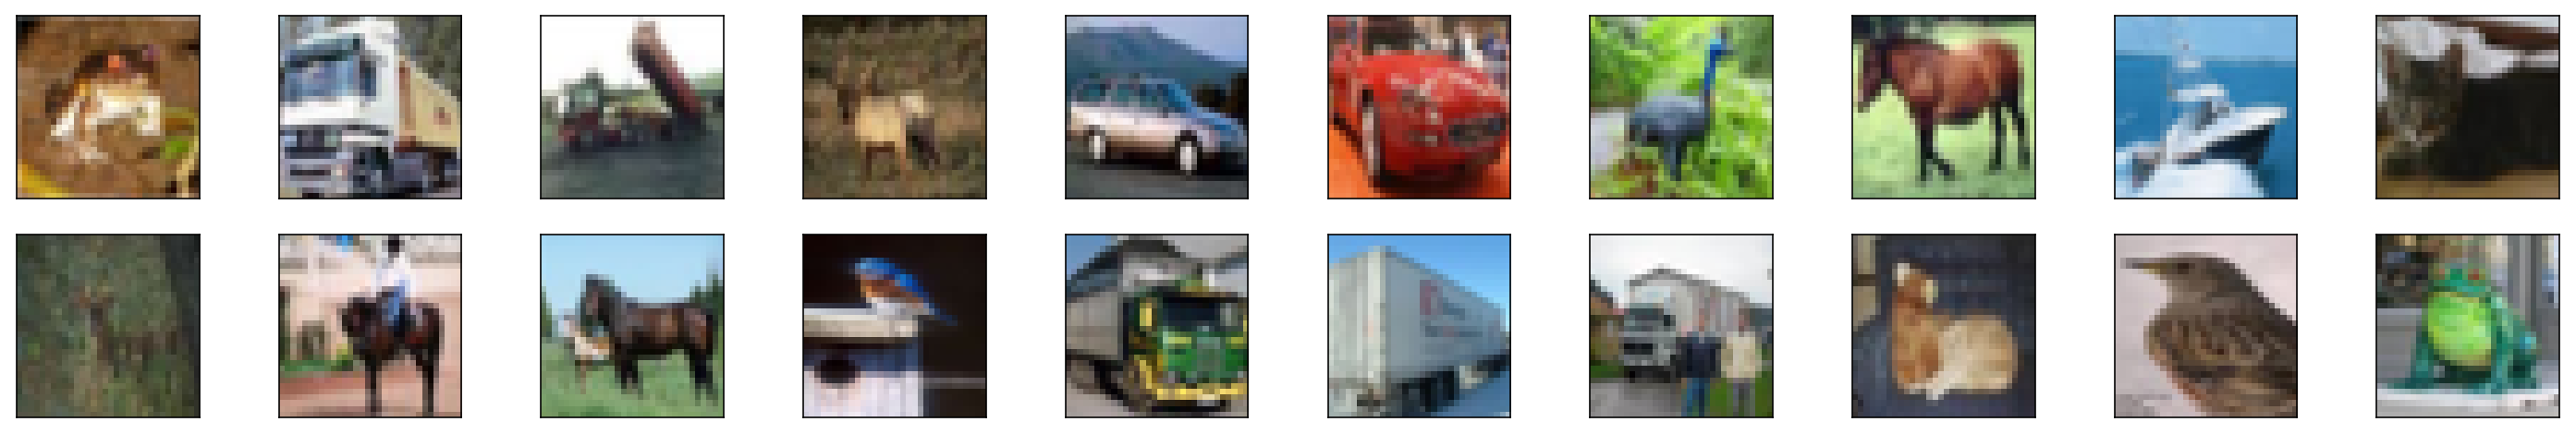

In [3]:
# Visualize some samples of the dataset
def visualize(images):
    fig = plt.figure(figsize=(25, 4))
    for index in np.arange(20):
        ax = fig.add_subplot(2, 20/2, index+1, xticks=[], yticks=[])
        ax.imshow(images[index].clip(0,1))
            
visualize(data.transpose(0,2,3,1)) # matplotlib assumes images of shape [height, width, num_channels]

# PCA Algorithm using SVD

PCA can be divided into 2 phases, (A) Compression, and (B) Recovery

### Compression

1. Zero center the data. This can be done by __subtracting mean of data__.
2. Perform __Singular Value Decomposition on Covariance Matrix__

    * __S__ - contains the square root of the eigenvalues of the covariance matrix and is sorted in descending order, meaning, the largest eigenvalue is the leftmost element. You can think of eigenvalues as representing the variances, therefore it is helpful to sort out eigenvectors according to their corresponding eigenvalues.
    * __U__ - contains the eigenvector of the covariance matrix. This is sorted parallely as $S$, that is, the eigenvectors correspond to the values in $S$
    * __V__ - you don't need this. NO, but seriously, if $U$ is the eigenvectors of ($A.T * A$), then $V$ is the eigenvectors of ($A * A.T$). In this case, since covariance matrix ($A$) is a square matrix, $V$ therefore is just the transpose of $U$.
  
    TL;DR: We only need $U$ because $U$ are the _decomposed factors_ used in projecting our data with reduced representation. 
    
3. Project original data in _top few_ eigenvectors.

You can now save the compressed representation of the data. You can also perform analysis on this reduced and cheaper version of your dataset. 

### Recovery

4. Multiply the transpose of _top few_ eigenvectors, to recover the data from the compressed/reduced/projected representation

5. Add mean of the original data to the recovered data.

In [4]:
def PCA(data, num_dim):
    # Reshape the data into flattened vectors [num_samples, -1]
    original_shape = data.shape
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1)

    # Get the mean and zero center the data
    mean = np.mean(data, axis=0) # per pixel mean
    data = data - mean

    # Get the covariance matrix
    cov = np.dot(data.T, data)
    
    # Perform factor Decomposition, using SVD
    U, S, V = np.linalg.svd(cov)
    
    # Project the data using fewer eigenvectors - [Compressed Representation] 
    data_compressed = np.dot(data, U[:, :num_dim])
    
    # Recover data from the compressed representation
    data_recovered = np.dot(data_compressed, U[:, :num_dim].transpose())
    
    # Add mean
    data_recovered += mean
    
    # Reshape to original shape
    data_recovered = data_recovered.reshape(*original_shape)
    
    return data_recovered, U, S

new_data_svd, U, S = PCA(data, 144)


(20, 3, 32, 32)


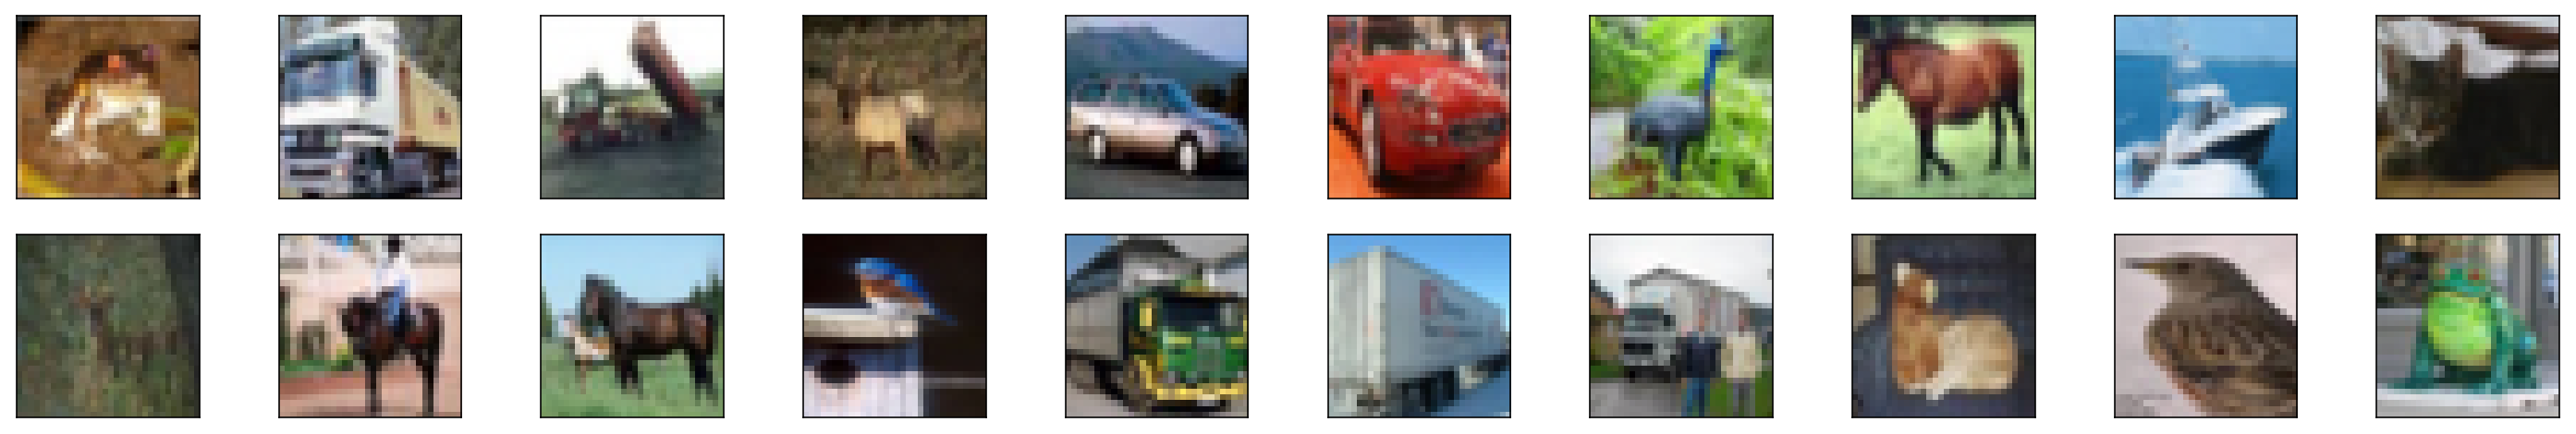

In [5]:
print(new_data_svd.shape)
visualize(new_data_svd.reshape(-1,3,32,32).transpose(0,2,3,1))

# HOW LOW CAN YOU BE!? How do I choose the number of Principal Components to use without losing much of the original information? 

You might be thinking, "HEY! Where did you get that 144? How did you know that you'll only need 144 vectors to represent the data? Did you just throw darts?" And the answer is, YES! 144 is arbitrarily chosen (actually I got the 144 value from [CS231N lecture notes](http://cs231n.github.io/neural-networks-2/)). No, but seriously, how do we know that a certain number of eigenvectors is enough? 

Well first, we need to define a measurement of similarity (or the dissimilarity) between the recovered data and the original data. There are many ways to do this: Compare their means. or Get their algebraic difference and set a threshold for the maximum allowed difference. Nonetheless, we'll use 2 heuristics in choosing a good number of Principle Components:

## 1. Average Squared Projection Error 

This effectively computes the __variance between the Original data and Recovered Data__. We want to our recovered data to be as similar as the original data as possible. In the formula below, we want at most 1% variance between the original data and the recovered data, that is, at least 99 % of the variance is retained 

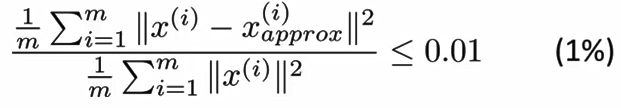
Picture from [ml-class.org](https://ml-class.org)

Tip: You may improve the find_min_dim() search algorithm by using more effective search algorithms, like binary search. 

In [6]:
# For this implementation, we can remove the (1/m)
def find_min_dim(data, U, variance=0.01, start=1):
    # Reshape the data into flattened vectors [num_samples, -1]
    original_shape = data.shape
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1) 
    
    # Get the mean and zero center the data
    data_original = data
    mean = np.mean(data, axis=0) # per pixel mean
    data = data - mean    
    
    # Get the denominator
    denominator = np.sum(data_original*data_original)
    right_side = variance * denominator
    
    # Number of Principal Components
    num_pcomp = data.shape[1]
    
    # Find the least number of Principal Components needed to satisfy variance condition
    for i in range (start, num_pcomp+1):
        # Usual PCA Compression and Recovery
        data_compressed = np.dot(data, U[:, :i])
        data_recovered = np.dot(data_compressed, U[:, :i].transpose())
        data_recovered += mean
        
        # Squared Error
        diff = data_original - data_recovered
        numerator = np.sum(diff*diff)
        left_side = numerator
        
        # Compare left side and right side
        if (left_side < right_side):
            break
            
    # Reshape recovered data
    data_recovered = data_recovered.reshape(*original_shape)
    
    return data_recovered, i

99.9% variance is retained using only 19/3072 Principal Components! OMG!


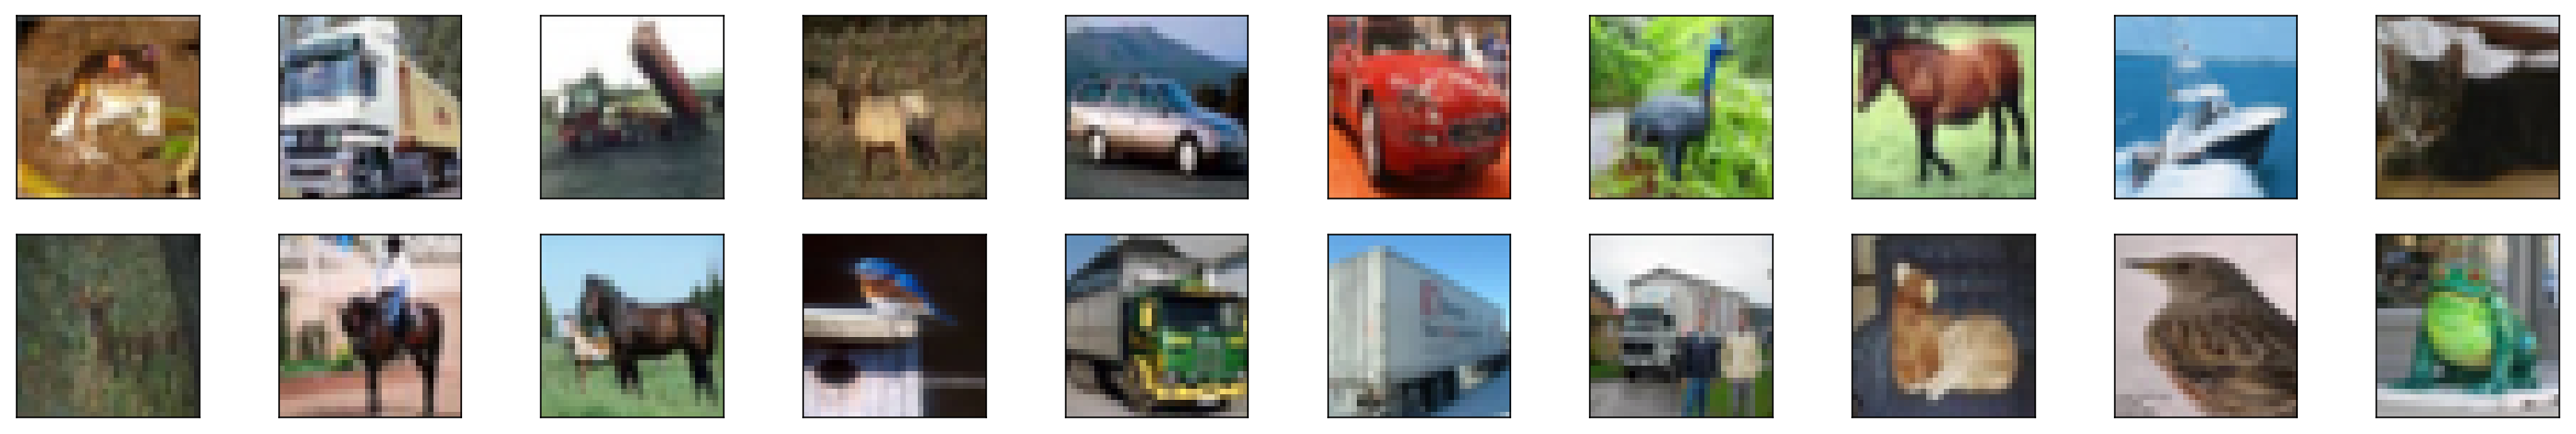

In [7]:
new_data_3, num_pcomp = find_min_dim(data, U, variance=0.001, start=1)
print("99.9% variance is retained using only {}/3072 Principal Components! OMG!".format(num_pcomp))
visualize(new_data_3.transpose(0,2,3,1))

## 2. Examine the Eigenvalues

As you see in the above example, 19 Principal Components/eigenvectors is enough to represent the data, while only losing 0.1% variance. In fact, if you play with the variance threshold of __find_min_dim()__, you'll see that even with 0.0000001 variance threshold, you will still only need 19 Principal Components. __Soooo, is there a way to know a good choice of principal components without iteratively compressing and recovering data?__ The answer is __YES!__

Recall that the $S$ matrix in the SVD decomposition --- and actually, in the Eigendecomposition ---, contains the sqaure root of the eigenvalues of the covariance matrix. Also, recall that eigenvalues can be interpreted as measurement of variances, that is, the bigger the eigenvalues, the more variance there is in that principal component, the more information is represented by that principal component. So we can examine the eigenvalues and choose the top few eigenvectors.

__Note that we don't care about the signs of eigenvalues. Signs just tell the direction of the vectors. Therefore, in plotting the eigenvalues, we need to take the absolute values of the eigenvalues.__

[1.1136564e+03 4.6628366e+02 3.1063528e+02 2.6376602e+02 2.0639316e+02
 1.6417995e+02 1.4323424e+02 1.2512427e+02 1.1212398e+02 1.0291894e+02
 9.2933365e+01 7.9086456e+01 7.3200157e+01 6.9195808e+01 6.5386314e+01
 5.2648373e+01 4.7328678e+01 3.2558750e+01 1.6197979e+01 5.0738408e-06
 5.0514082e-06 4.9978462e-06 4.9753821e-06 4.9386776e-06 4.9321061e-06]
19th eigenvalue: 16.197978973388672
20th eigenvalue: 5.073840839031618e-06


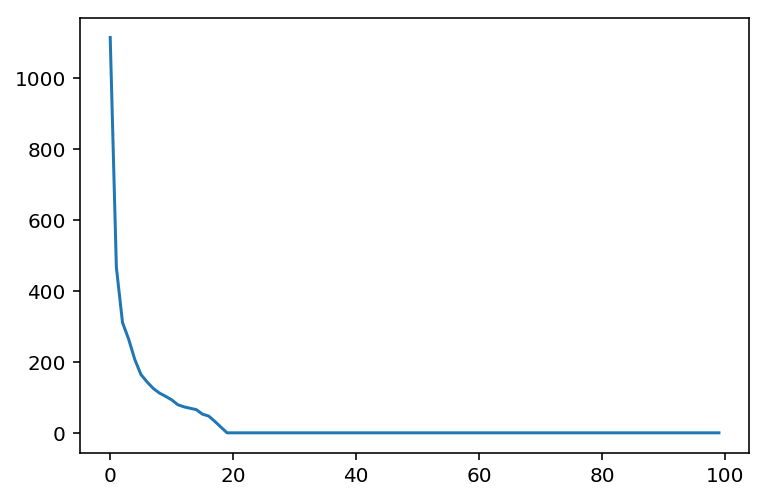

In [8]:
# Plot the top few eigenvalues
plt.plot(S[:100])

# From the graph, we see that eigenvalues "plateaud" starting at 20
print(S[:25])
print("19th eigenvalue: {}".format(S[18]))
print("20th eigenvalue: {}".format(S[19]))


From the graph above, we see that eigenvalues "plateaud" starting at 20. Printing the numerical values of $S$, we see that there is a __very very sharp decline between the 19th eigenvalue and the 20th eigenvalue__. That explains why we get 19 in Method 1: Average Squared Projection Error even with very small variance threshold.

# Faster PCA Algorithm using Eigendecomposition

Apparently, faster PCA calculation can be realized by using some tricks in Numpy.

1. Instead of manually calculating the covariance, use np.conv()
2. Instead of using SVD, using eigendecomposition. 

Eigendecomposition is just a special case of SVD, that is, eigendecomposition only works for square matrices. In our case, since we are passing covariance matrix, which in fact is a square matrix, to SVD, we can therefore use __np.linalg.eigh()__ to do decomposition. __np.linalg.eigh()__ is at least __3 times faster__ than np.linalg.svd() in small datasets

In [9]:
def PCA_faster(data, num_dim):
    # Reshape the data into flattened vectors [num_samples, -1]
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1)

    # Get the mean and zero center the data
    mean = np.mean(data, axis=0) # per pixel mean
    data = data - mean

    # Get the covariance matrix, Numpy has few tricks in computing covariance
    cov = np.cov(data.T)
    
    # Perform factor Decomposition, using SVD
    S, V = np.linalg.eigh(cov)
    
    # V is originally sorted in ascending eigenvalue, we want the opposite sorting
    V = np.fliplr(V)
    
    # Project the data using fewer eigenvectors - [Compressed Representation] 
    data_projected = np.dot(data, V[:, :num_dim])
    
    # Recover data from the compressed representation
    data_recovered = np.dot(data_projected, V[:, :num_dim].transpose())
    
    # Add mean
    data_recovered += mean
    
    return data_recovered, V, S
    
new_data_eigh, V, S_eig = PCA(data, 144)

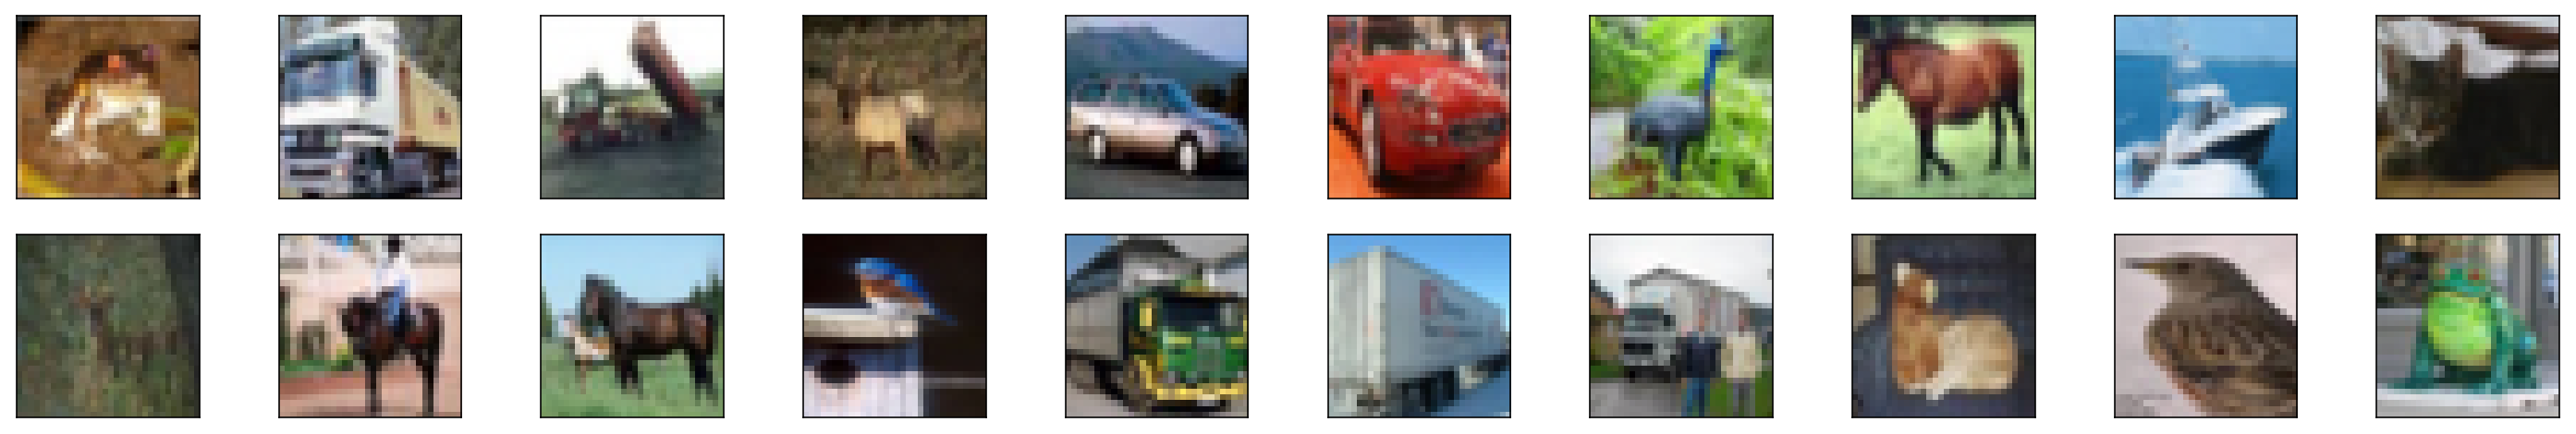

In [10]:
visualize(new_data_eigh.reshape(-1,3,32,32).transpose(0,2,3,1))

In [11]:
print(S_eig[:20])

[1.1136564e+03 4.6628366e+02 3.1063528e+02 2.6376602e+02 2.0639316e+02
 1.6417995e+02 1.4323424e+02 1.2512427e+02 1.1212398e+02 1.0291894e+02
 9.2933365e+01 7.9086456e+01 7.3200157e+01 6.9195808e+01 6.5386314e+01
 5.2648373e+01 4.7328678e+01 3.2558750e+01 1.6197979e+01 5.0738408e-06]


# PCA with SVD vs PCA with Eigendecomposition

Let's try applying PCA on whole CIFAR using those 2 implementations.

SPOILER: Eigendecomposition is faster than SVD, at least in the case of Numpy

In [13]:
import time

train_x = train_x.reshape(train_x.shape[0], -1)

start = time.time()
new_cifar_svd, _, _ = PCA(train_x, 144)
print("PCA with SVD: {} seconds".format(time.time() - start))

start_2 = time.time()
new_cifar_eigh, _, _ = PCA_faster(train_x, 144)
print("PCA with Eigendecomposition: {} seconds".format(time.time() - start_2))


PCA with SVD: 29.835537433624268 seconds
PCA with Eigendecomposition: 27.74350929260254 seconds


# Conclusion

So that's it. PCA! Did you notice any differences between the four data? Especially the data that are only using 19 principal compoenents?! 

### To summarize, PCA is just like natural selection minus mutation. PCA prioritizes _valuable members_ and also, discards those who are __WORTHLESS__ and _unpromising_! The overall population therefore is assumed to be represented as sum of those valuable members.

## So what's next?

How about:
1. Training neural networks (and other machine learning models) using the PCA-reduced representations as input?
2. Representations using Autoencoders (w/ and w/o non-linear activation functions)?
3. Using bigger dataset?
